In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import cell2location

/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


In [2]:
results_folder = './results/'

In [6]:
adata_vis = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

100%|██████████| 7.86M/7.86M [00:01<00:00, 7.30MB/s]
100%|██████████| 29.3M/29.3M [00:00<00:00, 46.3MB/s]
/home/wpy/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/wpy/miniconda3/envs/cell2loc/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [8]:
adata_vis.var['SYMBOL'] = adata_vis.var_names
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [9]:
# find mitochondria-encoded (MT) genes
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_vis.obsm['MT'] = adata_vis[:, adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [3]:
# Read data
adata_ref = sc.read(
    f'./RNA/sc.combined.clustered.h5'
)

Only considering the two last: ['.clustered', '.h5'].
Only considering the two last: ['.clustered', '.h5'].


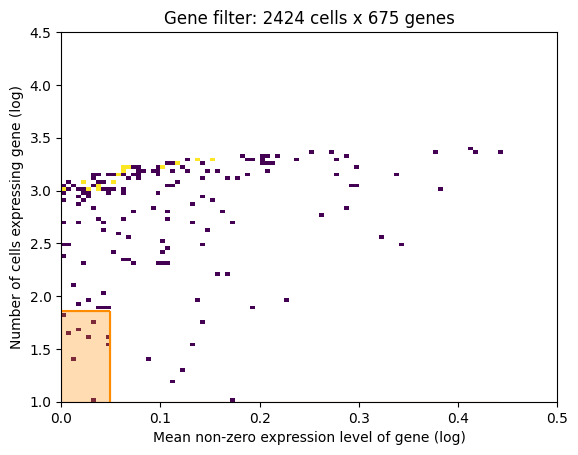

In [4]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [5]:
adata_ref.obs["annotations"] = "T"

In [6]:
sc.pp.filter_cells(adata_ref, min_counts=3, inplace=True)

In [8]:
adata_vis = sc.read_h5ad('./RNA/spatial.combined.annotation.h5')

In [11]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, adata_ref.var_names)
adata_filtered = adata_vis[:, intersect].copy()
ref_filtered = adata_ref[:, intersect].copy()

In [20]:
# create the regression model
from cell2location.models import RegressionModel
cell2location.models.RegressionModel.setup_anndata(adata=ref_filtered,
    labels_key='leiden'
)

/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


In [34]:
ref_filtered.obs.total_counts

AAACCTGAGAGACGAA-1    2452.0
AAACCTGAGTACTTGC-1    2606.0
AAACCTGCACGACGAA-1    5399.0
AAACGGGAGATGTGTA-1    5533.0
AAACGGGTCTCTAAGG-1    4326.0
                       ...  
TTTGCGCCATCACCCT-1    2129.0
TTTGCGCTCCTACAGA-1    2255.0
TTTGGTTGTAGCGCTC-1    1932.0
TTTGGTTGTTACTGAC-1    2181.0
TTTGTCAGTAAAGGAG-1    2042.0
Name: total_counts, Length: 2424, dtype: float32

In [54]:
(np.exp(ref_filtered.X.toarray()) - 1).T

array([[ 0.       ,  0.       ,  1.7154772, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  1.184716 ,  0.5718256, ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  2.859129 , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 1.2591836,  0.       ,  2.859129 , ...,  4.797822 , 14.203499 ,
         7.5649834],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 1.2591836,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]], dtype=float32)

In [56]:
data = (np.multiply((np.exp(ref_filtered.X.toarray()) - 1).T, ref_filtered.obs.total_counts.tolist()) / 10000).astype(int)

In [59]:
ref_filtered.X = data.T

In [60]:
mod = RegressionModel(ref_filtered)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': 'leiden',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   1   │
│         n_cells          │ 2424  │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   7   │
│          n_vars          │  665  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                         labels State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories        ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['leiden'] │  Central Memory Cd8+ T  │          0          │
│                     │     Effector Cd8+ T     │          1          │
│                     │ Effector Memory Cd8+ T  │          2          │
│                     │    Exhausted Cd8+ T     │          3          │
│                     │ Exhausted Memory Cd8+ T │          4          │
│                     │   Poliferating Cd8+ T   │          5          │
│                     │    Stem-like Cd8+ T     │          6          │
└─────────────────────┴─────────────────────────┴─────────────────────┘

In [63]:
mod.train(max_epochs=1000)

/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloa

Epoch 1000/1000: 100%|██████████| 1000/1000 [00:41<00:00, 26.96it/s, v_num=1, elbo_train=3.18e+5]

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [00:41<00:00, 23.95it/s, v_num=1, elbo_train=3.18e+5]


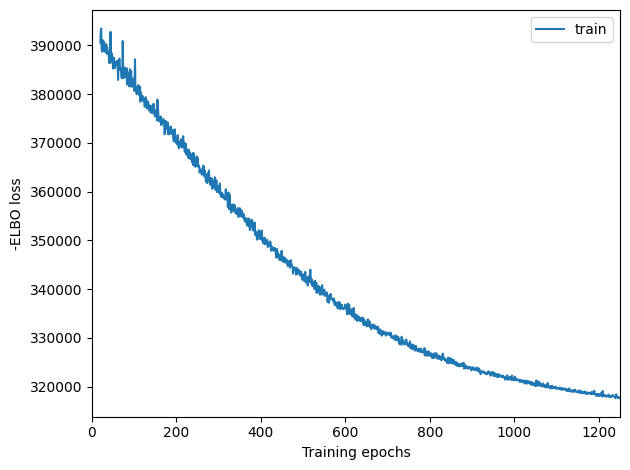

In [64]:
mod.plot_history(20)

In [65]:
adata_abd = mod.export_posterior(adata_filtered, sample_kwargs={'num_samples': 1000, 'batch_size':2500})

mod.save('./cache/estimate_abundance_model.npy', overwrite=True)

/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...


Sampling global variables, sample: 100%|██████████| 999/999 [00:05<00:00, 178.33it/s]


In [70]:
adata_abd.write_h5ad('./cache/estimate_abundance_model.h5')

In [68]:
adata_abd = mod.export_posterior(adata_filtered, use_quantiles=True, add_to_varm=['q05', 'q50', 'q95', 'q0001'], sample_kwargs={'batch_size': 2500})

In [79]:
inf_var = adata_abd.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_abd.uns['mod']['factor_names']]]
inf_var.columns = adata_abd.uns['mod']['factor_names']
inf_var.iloc[:5, :]

,Central Memory Cd8+ T,Effector Cd8+ T,Effector Memory Cd8+ T,Exhausted Cd8+ T,Exhausted Memory Cd8+ T,Poliferating Cd8+ T,Stem-like Cd8+ T
AA467197,0.069939,0.056254,0.001458,0.105044,0.158508,0.381711,0.027439
AC149090.1,0.010350,0.005287,0.040457,0.017390,0.028729,0.039338,0.008006
AC163354.1,0.009947,0.106726,0.001501,0.247493,0.292462,0.075135,0.042580
AL590144.2,0.001422,0.005290,0.001543,0.001391,0.001425,0.001445,0.001335
AW112010,7.315950,5.397281,3.712751,7.630564,10.662513,13.361362,5.525267


In [82]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_var.index)
adata_filtered = adata_vis[:, intersect].copy()
inf_var = inf_var.loc[intersect, :].copy()

# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_filtered, batch_key="marker")

In [84]:
mod = cell2location.models.Cell2location(
    adata_filtered,
    cell_state_df=inf_var,
    N_cells_per_location=1,
    detection_alpha=5
)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'marker',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│         n_batch          │   2    │
│         n_cells          │ 278122 │
│ n_extra_categorical_covs │   0    │
│ n_extra_continuous_covs  │   0    │
│         n_labels         │   1    │
│          n_vars          │  665   │
└──────────────────────────┴────────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['marker'] │     A      │          0          │
│                     │     B      │          1          │
└─────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [97]:
mod.train(max_epochs=1000,
    batch_size=10000,
    train_size=1
)

/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...
/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Epoch 1000/1000: 100%|██████████| 1000/1000 [4:02:58<00:00, 15.57s/it, v_num=1, elbo_train=3.2e+7] 

`Trainer.fit` stopped: `max_epochs=1000` reached.


Epoch 1000/1000: 100%|██████████| 1000/1000 [4:02:58<00:00, 14.58s/it, v_num=1, elbo_train=3.2e+7]


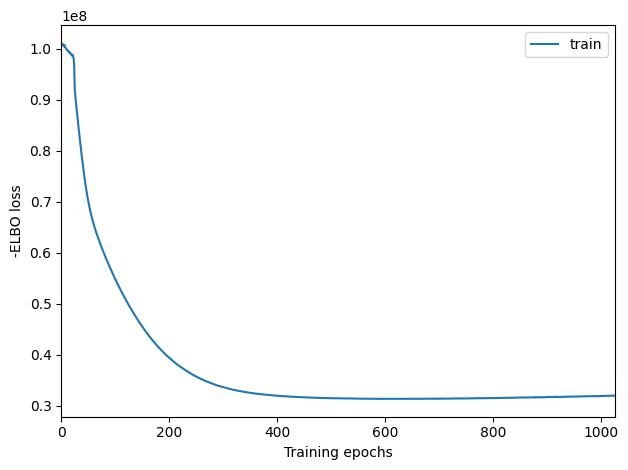

In [98]:
mod.plot_history()

In [107]:
adata_filtered.write_h5ad("./cache/mapping.h5")

In [2]:
adata_filtered = sc.read_h5ad('./cache/mapping.h5')
mod = cell2location.models.Cell2location.load('./cache/mapping.npy', adata_filtered)

INFO     File ./cache/mapping.npy/model.pt already downloaded                                                      


/home/wpy/miniconda3/envs/cell2loc/lib/python3.11/site-packages/lightning/fabric/plugins/environments/slurm.py:168: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cell2loc/lib/python3.11/si ...
<frozen abc>:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

2024-07-22 19:49:27.202361: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
/home/wpy/miniconda3/envs/cell2lo

Epoch 1/30000:   0%|          | 1/30000 [00:09<77:36:45,  9.31s/it, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/30000:   0%|          | 1/30000 [00:09<77:51:44,  9.34s/it, v_num=1]


In [5]:
adata_mod = mod.export_posterior(adata_filtered, sample_kwargs={'num_samples': 400, 'batch_size': 10000})

Sampling local variables, batch:   0%|          | 0/28 [00:00<?, ?it/s]

Sampling global variables, sample: 100%|██████████| 399/399 [00:12<00:00, 32.25it/s]


In [56]:
adata_mod.write_h5ad('./cache/mapping.mod.h5')

In [10]:
adata_mod.uns['mod']["factor_names"]

['Central Memory Cd8+ T',
 'Effector Cd8+ T',
 'Effector Memory Cd8+ T',
 'Exhausted Cd8+ T',
 'Exhausted Memory Cd8+ T',
 'Poliferating Cd8+ T',
 'Stem-like Cd8+ T']

In [13]:
import matplotlib as mpl

In [33]:
adata_mod.uns['mod'].keys()

dict_keys(['model_name', 'date', 'factor_filter', 'factor_names', 'var_names', 'obs_names', 'post_sample_means', 'post_sample_stds', 'post_sample_q05', 'post_sample_q95'])

In [43]:
adata_mod.obs[adata_mod.uns['mod']['factor_names']] = adata_mod.obsm['q05_cell_abundance_w_sf']

In [49]:
colors = mpl.cm.get_cmap("Set2")

/tmp/ipykernel_314374/2437998958.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = mpl.cm.get_cmap("Set2")


In [55]:
import squidpy as sq

ModuleNotFoundError: No module named 'squidpy'

NameError: name 'sq' is not defined

In [14]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial
from cell2location.utils import select_slide

# select up to 6 clusters
clust_labels = adata_mod.uns['mod']["factor_names"]
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

#slide = select_slide(adata_mod, 'A')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=adata_mod,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )

KeyError: 'spatial'

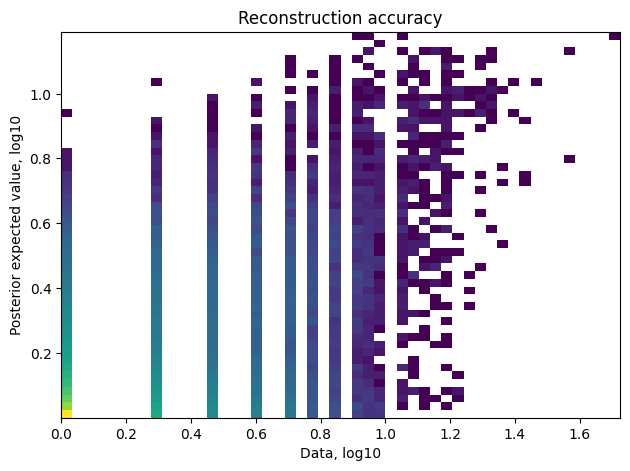

In [6]:
mod.plot_QC()

In [106]:
mod.save("./cache/mapping.npy", overwrite=True)

In [ ]:
mod.plot_QC()